## M1: Exploratory Data Analysis (EDA)

In [ ]:
#%pip install numpy pandas matplotlib seaborn scikit-learn shap lime joblib

In [8]:
#import libraries..
import numpy as np
import pandas as pd
import json
import os
import time
from datetime import datetime
import logging
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib
matplotlib.use('Agg')  # For non-interactive environments
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Profiling
from pandas_profiling import ProfileReport

# Scikit-learn Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Model Explanation
import shap
import lime
import lime.lime_tabular

# External ML Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Hyperparameter Optimization
import optuna

# Model Persistence
import joblib

# Statistical Testing
from scipy.stats import ks_2samp

# Experiment Tracking
import mlflow
import mlflow.sklearn

In [9]:
# Load Fashion MNIST dataset from CSV files
train_data = pd.read_csv("data/fashion-mnist_train.csv")
test_data = pd.read_csv("data/fashion-mnist_test.csv")

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Assuming the label is the first column (typical format)
# If it's in a different position, adjust accordingly
y_train = train_data.iloc[:, 0]
X_train = train_data.iloc[:, 1:] # pixel1 to pixel784
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:] # pixel1 to pixel784

# Define class names for better interpretation (classes 0-9)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a sample dataframe for profiling (using a subset for efficiency)
sample_size = 5000
df_sample = X_train.iloc[:sample_size].copy()
df_sample['class'] = [class_names[y] for y in y_train[:sample_size]]

# Generate the pandas profiling report
profile = ProfileReport(df_sample, title="Fashion MNIST EDA", 
                       minimal=True, 
                       explorative=True)

# Save the report
profile.to_file("output/M1_fashion_mnist_eda_report.html")


Training data shape: (60000, 785)
Testing data shape: (10000, 785)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 785/785 [00:01<00:00, 409.78it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

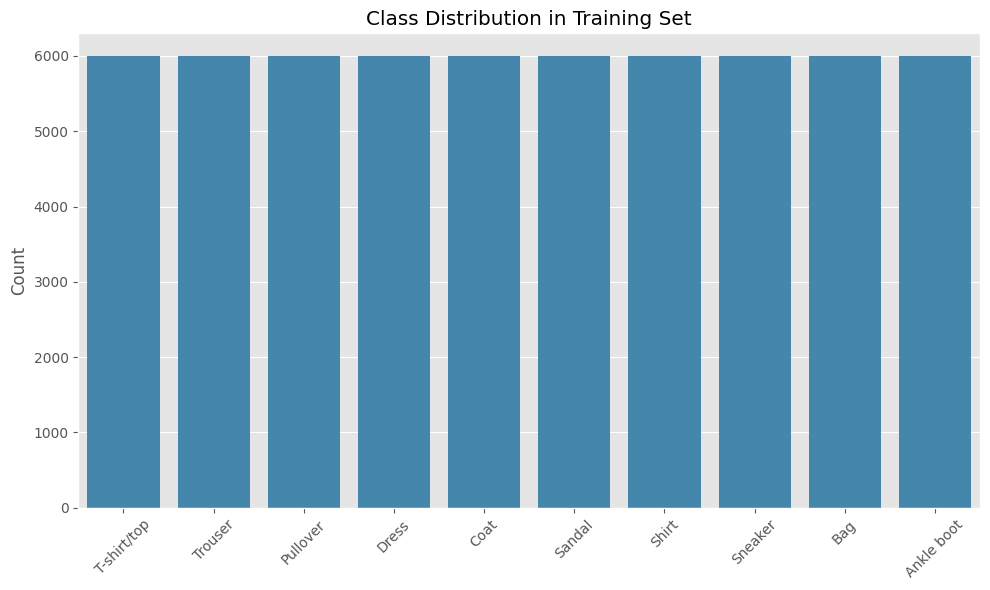

In [20]:
# Display class distribution
default_color = sns.color_palette()[1]  # This is usually the light blue
plt.figure(figsize=(10, 6))
train_class_counts = y_train.value_counts().sort_index()
sns.barplot(x=[class_names[i] for i in train_class_counts.index], 
            y=train_class_counts.values, color=default_color)
plt.title('Class Distribution in Training Set')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/M1_class_distribution.png')
plt.show()

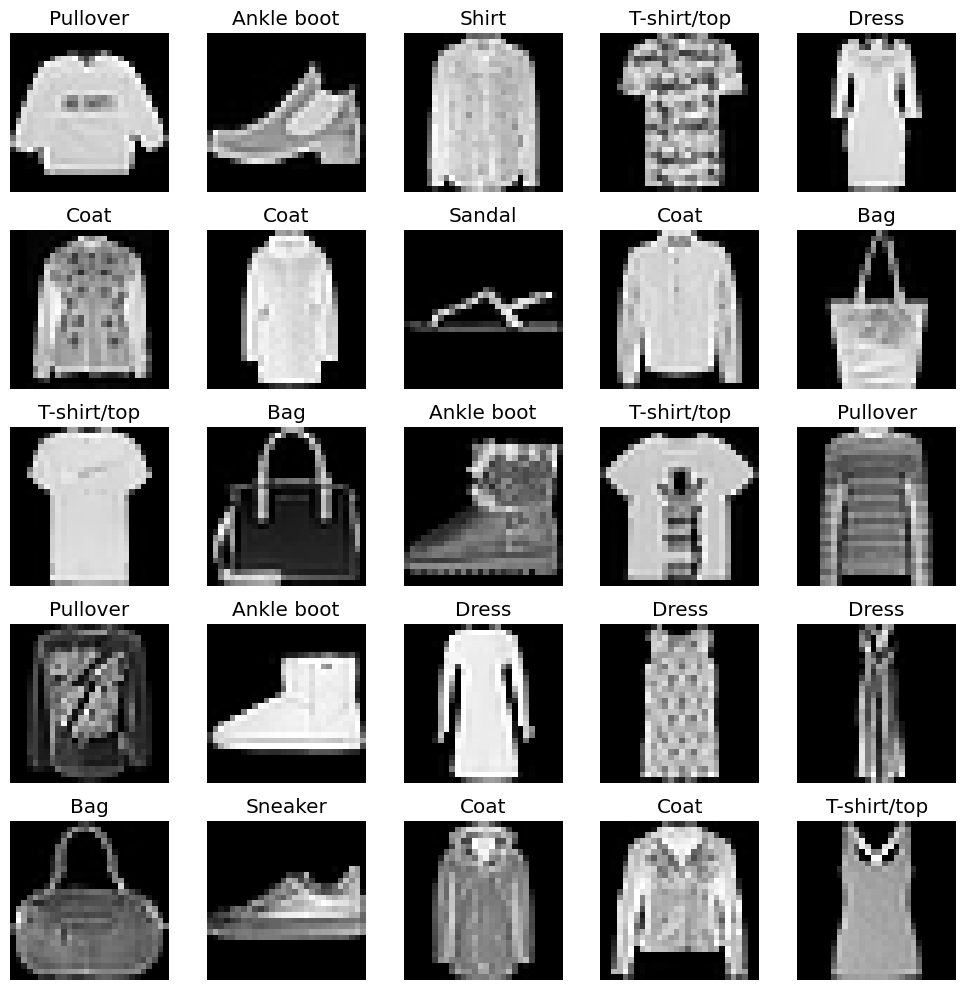

In [12]:
# Display a few sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = X_train.iloc[i].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(class_names[y_train.iloc[i]])
    plt.axis('off')
plt.tight_layout()
plt.savefig('output/M1_sample_images.png')
plt.show()

In [13]:
# Check for missing values
print("Missing values in training data:", X_train.isnull().sum().sum())
print("Missing values in test data:", X_test.isnull().sum().sum())

# Basic statistics
print("\nPixel value statistics:")
pixel_stats = X_train.describe()
print(pixel_stats)

Missing values in training data: 0
Missing values in test data: 0

Pixel value statistics:
             pixel1        pixel2        pixel3        pixel4        pixel5  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000900      0.006150      0.035333      0.101933      0.247967   
std        0.094689      0.271011      1.222324      2.452871      4.306912   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     36.000000    226.000000    164.000000    227.000000   

             pixel6        pixel7        pixel8        pixel9       pixel10  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.411467      0.805767      

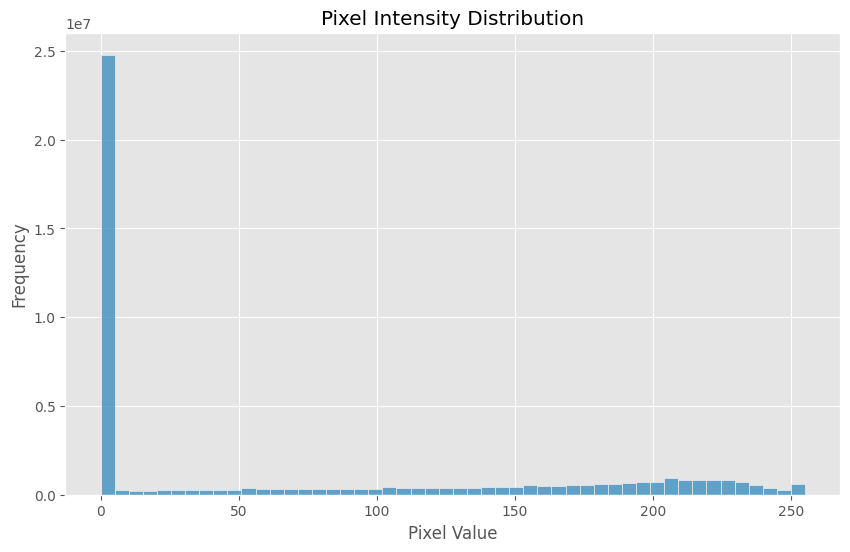

In [24]:
# Plot pixel intensity distribution
plt.figure(figsize=(10, 6))
sns.histplot(X_train.values.flatten(), bins=50, color=default_color)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.savefig('output/M1_pixel_distribution.png')
plt.show()

## M2: Feature Engineering & Explainability

In [25]:
# Load the data
train_data = pd.read_csv("data/fashion-mnist_train.csv")
test_data = pd.read_csv("data/fashion-mnist_test.csv")

# Split into features and target
y_train = train_data.iloc[:, 0]
X_train = train_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [26]:
# Enhanced Feature Engineering Pipeline
def enhanced_feature_engineering_pipeline(X_train, X_test):
    # Step 1: Normalize the data
    X_train_norm = X_train / 255.0
    X_test_norm = X_test / 255.0
    
    # Step 2: Apply PCA with more components for better feature representation
    pca = PCA(n_components=100, random_state=42)
    X_train_pca = pca.fit_transform(X_train_norm)
    X_test_pca = pca.transform(X_test_norm)
    
    # Step 3: Add statistical features
    X_train_stats = pd.DataFrame({
        'mean': X_train_norm.mean(axis=1),
        'std': X_train_norm.std(axis=1),
        'max': X_train_norm.max(axis=1),
        'min': X_train_norm.min(axis=1)
    })
    
    X_test_stats = pd.DataFrame({
        'mean': X_test_norm.mean(axis=1),
        'std': X_test_norm.std(axis=1),
        'max': X_test_norm.max(axis=1),
        'min': X_test_norm.min(axis=1)
    })
    
    # Step 4: Combine PCA and statistical features
    X_train_combined = np.hstack([X_train_pca, X_train_stats])
    X_test_combined = np.hstack([X_test_pca, X_test_stats])
    
    # Step 5: Scale the combined features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_test_scaled = scaler.transform(X_test_combined)
    
    # Create feature names
    feature_names = [f'pca_{i+1}' for i in range(100)] + ['mean', 'std', 'max', 'min']
    X_train_final = pd.DataFrame(X_train_scaled, columns=feature_names)
    X_test_final = pd.DataFrame(X_test_scaled, columns=feature_names)
    
    return X_train_final, X_test_final, pca, scaler

# Apply enhanced feature engineering
X_train_processed, X_test_processed, pca, scaler = enhanced_feature_engineering_pipeline(X_train, X_test)

print("Original data shape:", X_train.shape)
print("Processed data shape:", X_train_processed.shape)

Original data shape: (60000, 784)
Processed data shape: (60000, 104)


Enhanced model accuracy: 0.8659


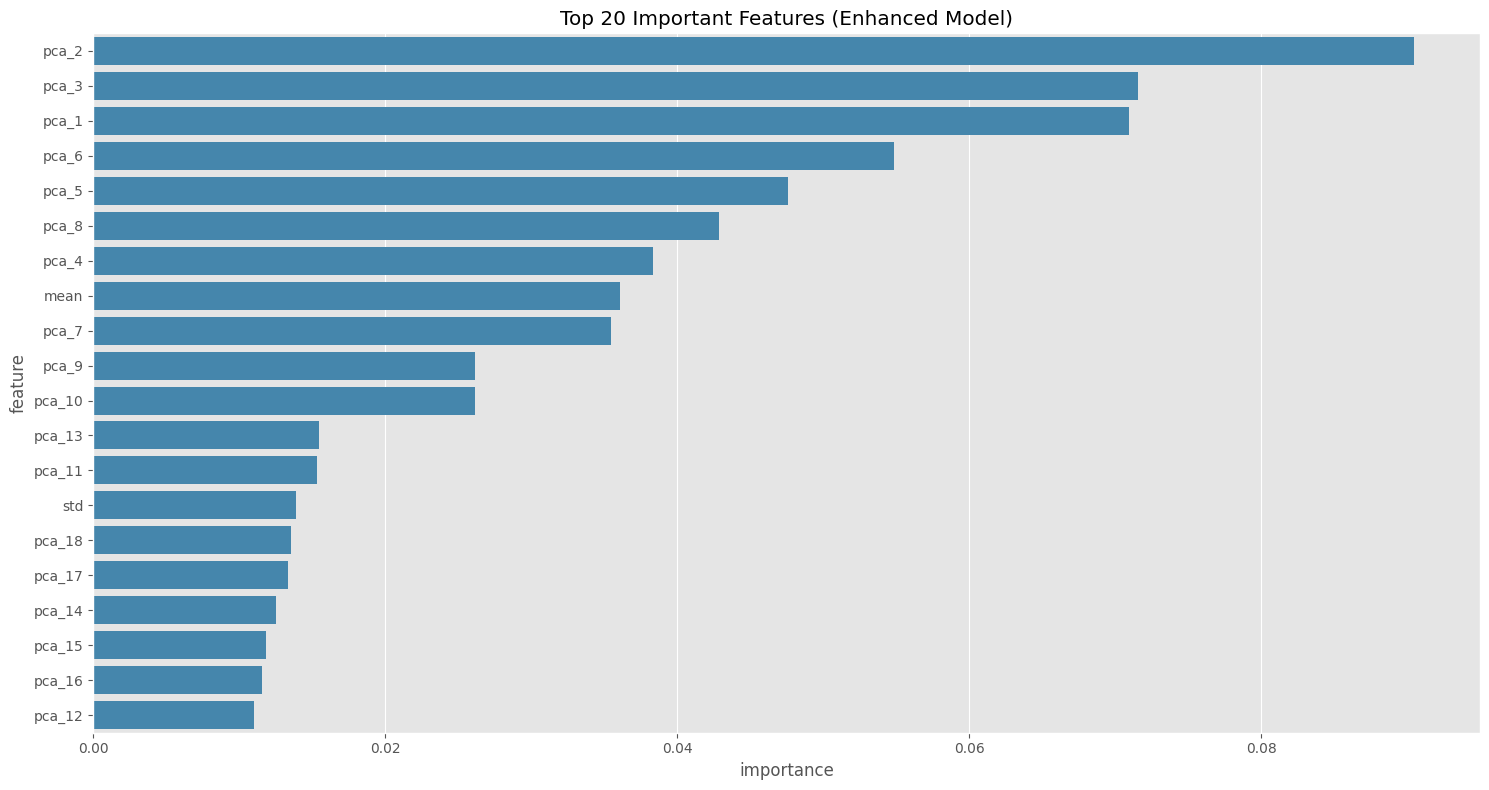

In [28]:
# Train a more sophisticated model
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train_processed, y_train)
accuracy = model.score(X_test_processed, y_test)
print(f"Enhanced model accuracy: {accuracy:.4f}")

# Enhanced Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20),color=default_color)
plt.title('Top 20 Important Features (Enhanced Model)')
plt.tight_layout()
plt.savefig('output/M2_enhanced_feature_importance.png')
plt.show()
plt.close()

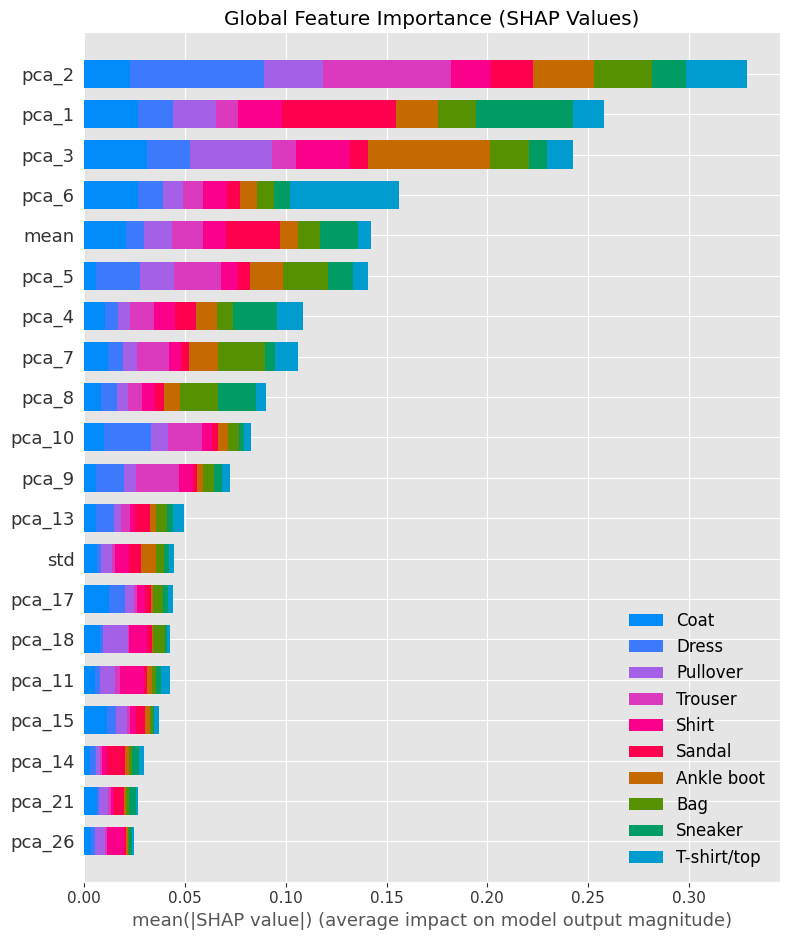

In [29]:
# SHAP Analysis with Enhanced Features
X_explain = X_test_processed.iloc[:100]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_explain)

# Global SHAP Summary Plot
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_explain, plot_type="bar", class_names=class_names, show=False)
plt.title('Global Feature Importance (SHAP Values)')
plt.tight_layout()
plt.savefig('output/M2_enhanced_shap_summary.png')
plt.show()
plt.close()

<Figure size 1000x600 with 0 Axes>

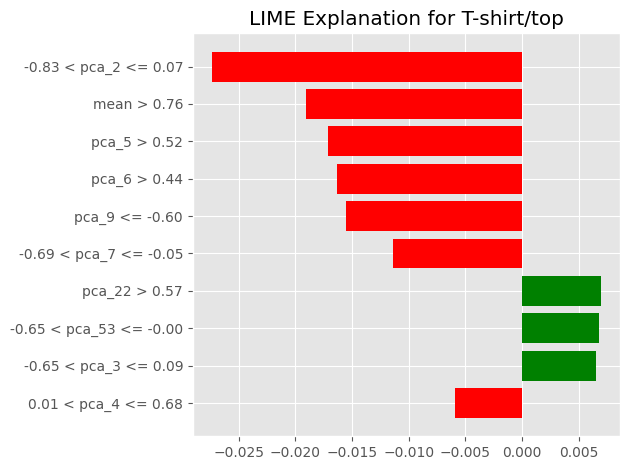

<Figure size 1000x600 with 0 Axes>

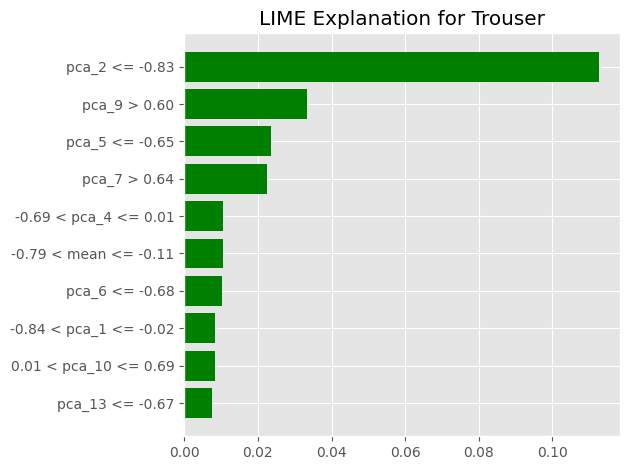

<Figure size 1000x600 with 0 Axes>

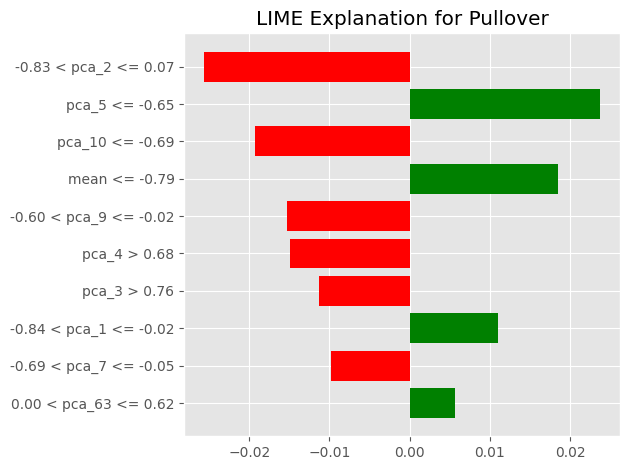

In [30]:
# LIME Analysis
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_processed.values,
    feature_names=X_train_processed.columns,
    class_names=class_names,
    mode='classification'
)

# Generate LIME explanations for a few examples
for i in range(3):
    exp = explainer.explain_instance(X_test_processed.iloc[i].values, model.predict_proba)
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for {class_names[y_test.iloc[i]]}')
    plt.tight_layout()
    plt.savefig(f'output/M2_lime_explanation_{i}.png')
    plt.show()
    plt.close()

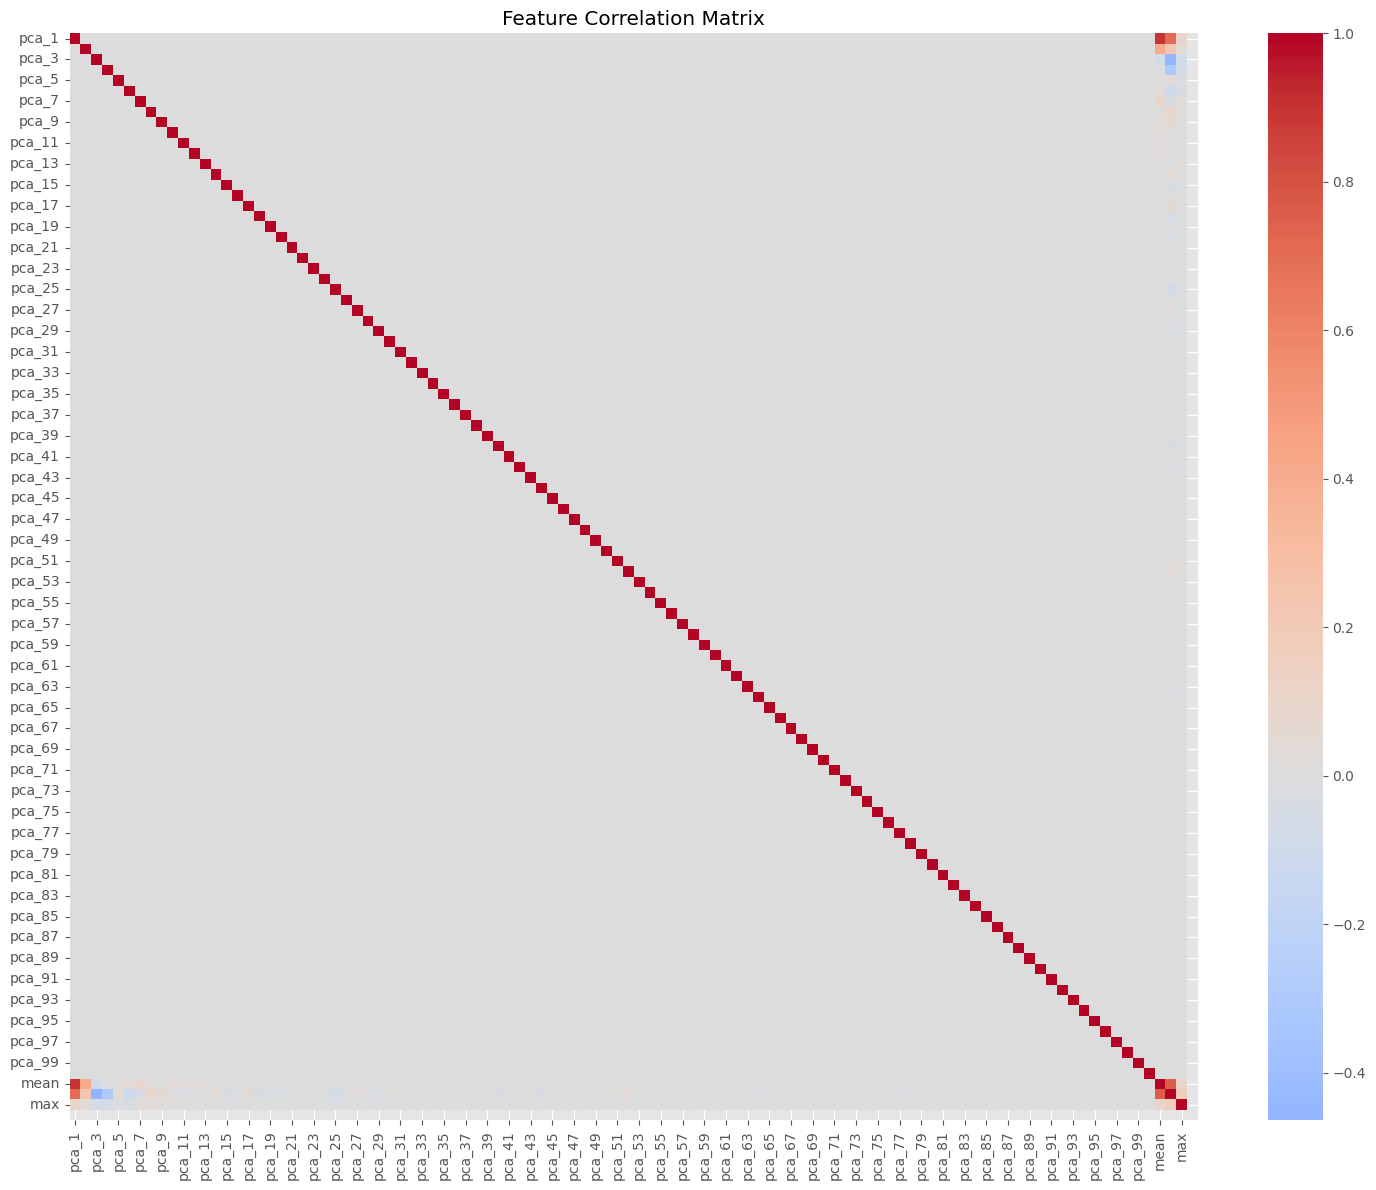

In [31]:
# Feature Correlation Analysis
plt.figure(figsize=(15, 12))
correlation_matrix = X_train_processed.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('output/M2_feature_correlation.png')
plt.show()
plt.close()

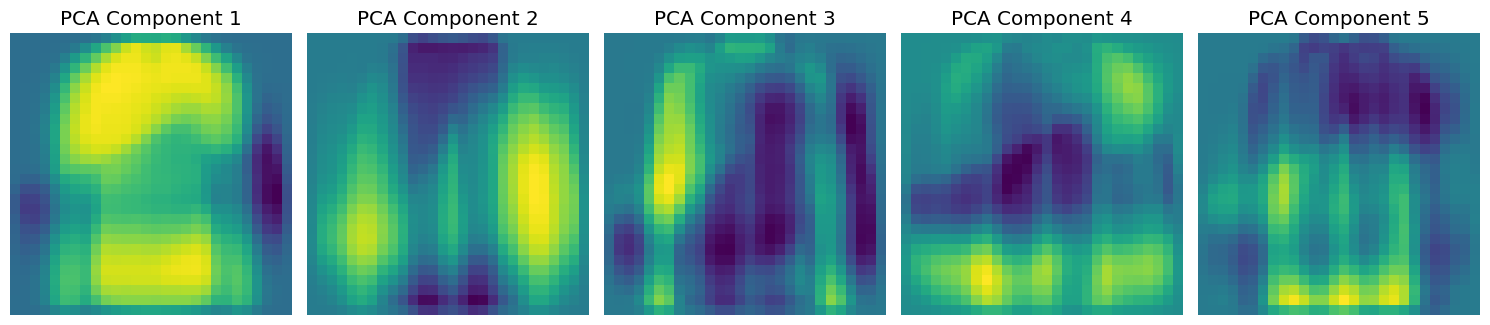

In [33]:
# Visualize PCA Components with Statistical Features
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap='viridis')
    plt.title(f'PCA Component {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('output/M2_enhanced_pca_components.png')
plt.show()
plt.close()

In [34]:

# Save enhanced model artifacts
import joblib
joblib.dump(pca, 'models/enhanced_pca.joblib')
joblib.dump(scaler, 'models/enhanced_scaler.joblib')
joblib.dump(model, 'models/enhanced_rf_model.joblib')

print("Enhanced feature engineering and explainability analysis completed. Check saved visualizations.")

Enhanced feature engineering and explainability analysis completed. Check saved visualizations.


## M3: Model Selection & Hyperparameter Optimization - 10M   

In [ ]:
# Create output directories if they don't exist
os.makedirs('processed_data', exist_ok=True)
os.makedirs('current_data', exist_ok=True)
os.makedirs('output', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('logs/M3_model_optimization.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('model_optimization')

# Start time for overall process
start_time = time.time()
logger.info(f"Starting model selection and hyperparameter optimization at {datetime.now()}")

# Load the preprocessed data (assuming the feature engineering pipeline from M2 was applied)
def load_preprocessed_data():
    try:
        # Try to load the already processed data
        logger.info("Trying to load preprocessed data and model artifacts...")
        X_train_processed = pd.read_csv('processed_data/X_train_processed.csv')
        X_test_processed = pd.read_csv('processed_data/X_test_processed.csv')
        y_train = pd.read_csv('processed_data/y_train.csv', header=None).iloc[:, 0]
        y_test = pd.read_csv('processed_data/y_test.csv', header=None).iloc[:, 0]
        
        pca = joblib.load('models/enhanced_pca.joblib')
        scaler = joblib.load('models/enhanced_scaler.joblib')
        
        logger.info("Successfully loaded preprocessed data and model artifacts")
    except (FileNotFoundError, IOError):
        logger.info("Preprocessed data not found, loading raw data and applying processing...")
        
        # Load raw data
        train_data = pd.read_csv("data/fashion-mnist_train.csv")
        test_data = pd.read_csv("data/fashion-mnist_test.csv")
        
        # Split into features and target
        y_train = train_data.iloc[:, 0]
        X_train = train_data.iloc[:, 1:]
        y_test = test_data.iloc[:, 0]
        X_test = test_data.iloc[:, 1:]
        
        # Load the feature engineering pipeline 
        logger.info("Applying feature engineering pipeline...")
        from enhanced_feature_engineering import enhanced_feature_engineering_pipeline
        
        X_train_processed, X_test_processed, pca, scaler = enhanced_feature_engineering_pipeline(X_train, X_test)
        
        # Save the processed data for future use
        X_train_processed.to_csv('processed/X_train_processed.csv', index=False)
        X_test_processed.to_csv('processed/X_test_processed.csv', index=False)
        y_train.to_csv('data/y_train.csv', index=False, header=False)
        y_test.to_csv('data/y_test.csv', index=False, header=False)
        
        logger.info("Successfully processed and saved data")
    
    return X_train_processed, X_test_processed, y_train, y_test, pca, scaler

# Load data
X_train_processed, X_test_processed, y_train, y_test, pca, scaler = load_preprocessed_data()

logger.info(f"Loaded processed training data with shape: {X_train_processed.shape}")
logger.info(f"Loaded processed test data with shape: {X_test_processed.shape}")

# Define class names for better visualization
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#-------------------------------------------------
# Part 1: AutoML Model Selection
#-------------------------------------------------

logger.info("Starting AutoML Model Selection Phase")

# Define a list of candidate models with default hyperparameters
candidate_models = [
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': 100, 'max_depth': 10}
    },
    {
        'name': 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': 100, 'learning_rate': 0.1}
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42),
        'params': {'n_estimators': 100, 'learning_rate': 0.1}
    },
    {
        'name': 'LightGBM',
        'model': LGBMClassifier(random_state=42),
        'params': {'n_estimators': 100, 'learning_rate': 0.1}
    },
    {
        'name': 'SVM',
        'model': SVC(probability=True, random_state=42),
        'params': {'C': 1.0, 'kernel': 'rbf'}
    },
    {
        'name': 'MLP',
        'model': MLPClassifier(random_state=42),
        'params': {'hidden_layer_sizes': (100,), 'max_iter': 300}
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': 5}
    }
]

# Evaluate each model and collect results
automl_results = []

for model_info in candidate_models:
    model_name = model_info['name']
    model = model_info['model']
    
    logger.info(f"Training {model_name} with default parameters...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    train_time = time.time() - start_time
    
    # Save results
    result = {
        'model_name': model_name,
        'accuracy': accuracy,
        'train_time': train_time
    }
    automl_results.append(result)
    
    logger.info(f"{model_name} - Accuracy: {accuracy:.4f}, Training Time: {train_time:.2f} seconds")

# Convert results to DataFrame for easier visualization
automl_df = pd.DataFrame(automl_results)
automl_df = automl_df.sort_values('accuracy', ascending=False)

# Save results
automl_df.to_csv('output/M3_automl_results.csv', index=False)

# Visualize AutoML results
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='model_name', y='accuracy', data=automl_df)
plt.title('Model Comparison - Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/M3_automl_comparison.png')
plt.close()

# Visualize training time
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='model_name', y='train_time', data=automl_df)
plt.title('Model Comparison - Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/M3_automl_training_time.png')
plt.close()

# Select the best model from AutoML
best_model_name = automl_df.iloc[0]['model_name']
best_model_accuracy = automl_df.iloc[0]['accuracy']

logger.info(f"Best model from AutoML phase: {best_model_name} with accuracy {best_model_accuracy:.4f}")

# Find the corresponding model object from our candidate_models list
best_model = next(model_info['model'] for model_info in candidate_models if model_info['name'] == best_model_name)

#-------------------------------------------------
# Part 2: Hyperparameter Optimization with Optuna
#-------------------------------------------------

logger.info(f"Starting Hyperparameter Optimization for {best_model_name} with Optuna")

# Define hyperparameter search spaces based on the best model
def get_param_search_space(model_name):
    if model_name == 'Random Forest':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 50, 1000, step=50)
            max_depth = trial.suggest_int('max_depth', 5, 30, step=5)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy
    
    elif model_name == 'Gradient Boosting':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            
            model = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                subsample=subsample,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy
    
    elif model_name == 'XGBoost':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            
            model = XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy
    
    elif model_name == 'LightGBM':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            num_leaves = trial.suggest_int('num_leaves', 20, 100, step=10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            
            model = LGBMClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                num_leaves=num_leaves,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy
    
    elif model_name == 'SVM':
        def objective(trial):
            C = trial.suggest_float('C', 0.1, 100.0, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
            gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
            
            model = SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                probability=True,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy
    
    elif model_name == 'MLP':
        def objective(trial):
            hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [
                (50,), (100,), (50, 50), (100, 50), (100, 100)
            ])
            activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
            alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
            learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
            max_iter = trial.suggest_int('max_iter', 100, 500, step=100)
            
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                max_iter=max_iter,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy

    elif model_name == 'KNN':
        def objective(trial):
            n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
            p = trial.suggest_int('p', 1, 2)  # p=1 for manhattan_distance, p=2 for euclidean_distance
            
            model = KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights=weights,
                algorithm=algorithm,
                p=p
            )
            
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
            return accuracy
    
    else:
        raise ValueError(f"Model {model_name} not supported for hyperparameter tuning")
    
    return objective

# Get the objective function for the best model
objective = get_param_search_space(best_model_name)

# Create a new Optuna study
study = optuna.create_study(direction='maximize', study_name=f'{best_model_name}_optimization')

# Define early stopping callback
def early_stopping_callback(study, trial):
    """Stop optimization if no improvement in the last several trials."""
    
    # Parameters for early stopping
    n_warmup = 3  # Minimum number of trials before checking for early stopping
    n_patience = 3  # Number of trials to wait for improvement
    min_improvement = 0.001  # Minimum improvement in accuracy considered meaningful
    
    # Skip early stopping if we haven't done enough trials
    if trial.number <= n_warmup:
        return False
        
    # Get completed trials with values
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None]
    if len(completed_trials) <= n_warmup:
        return False
    
    # Current best value
    best_value = study.best_value
    
    # Check if there's been a meaningful improvement in the last n_patience trials
    recent_best = max([t.value for t in completed_trials[-n_patience-1:-1] if t.value is not None], default=0)
    
    # Calculate improvement
    improvement = best_value - recent_best
    
    # Log the improvement
    logger.info(f"Trial {trial.number}: Current best: {best_value:.6f}, Recent best: {recent_best:.6f}, Improvement: {improvement:.6f}")
    
    # If improvement is very small or negative, stop
    if improvement < min_improvement:
        logger.info(f"Stopping optimization early: Improvement of {improvement:.6f} is below threshold of {min_improvement}")
        return True
    
    return False

# Run the optimization with early stopping
study.optimize(objective, n_trials=10, show_progress_bar=True, callbacks=[early_stopping_callback])

# Get the best parameters and score
best_params = study.best_params
best_score = study.best_value

logger.info(f"Best hyperparameters for {best_model_name}: {best_params}")
logger.info(f"Best accuracy score: {best_score:.4f}")

# Plot optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title(f'Optimization History for {best_model_name}')
plt.tight_layout()
plt.savefig('output/M3_optuna_optimization_history.png')
plt.close()

# Plot parameter importances
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title(f'Parameter Importances for {best_model_name}')
plt.tight_layout()
plt.savefig('output/M3_optuna_param_importances.png')
plt.close()

# Create the final model with the best hyperparameters
if best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(**best_params, random_state=42)
elif best_model_name == 'Gradient Boosting':
    final_model = GradientBoostingClassifier(**best_params, random_state=42)
elif best_model_name == 'XGBoost':
    final_model = XGBClassifier(**best_params, random_state=42)
elif best_model_name == 'LightGBM':
    final_model = LGBMClassifier(**best_params, random_state=42)
elif best_model_name == 'SVM':
    final_model = SVC(**best_params, probability=True, random_state=42)
elif best_model_name == 'MLP':
    final_model = MLPClassifier(**best_params, random_state=42)
elif best_model_name == 'KNN':
    final_model = KNeighborsClassifier(**best_params)

# Train the final model
logger.info("Training final model with optimized hyperparameters...")
final_model.fit(X_train_processed, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test_processed)
final_accuracy = accuracy_score(y_test, y_pred)
logger.info(f"Final model accuracy: {final_accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_names)
logger.info(f"Classification Report:\n{report}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name} (Optimized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('output/M3_confusion_matrix_optimized.png')
plt.close()

# Save the final model
joblib.dump(final_model, f'models/optimized_{best_model_name.lower().replace(" ", "_")}.joblib')

# Calculate improvement from default to optimized
default_accuracy = best_model_accuracy
improvement = ((final_accuracy - default_accuracy) / default_accuracy) * 100

logger.info(f"Model improvement after optimization: {improvement:.2f}%")

# Create a dictionary to store model metadata
model_metadata = {
    'model_name': best_model_name,
    'default_accuracy': default_accuracy,
    'optimized_accuracy': final_accuracy,
    'improvement_percentage': improvement,
    'best_hyperparameters': best_params,
    'feature_count': X_train_processed.shape[1],
    'training_samples': X_train_processed.shape[0],
    'test_samples': X_test_processed.shape[0]
}

# Save model metadata as JSON
import json
with open('models/optimized_model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

# Generate model selection and optimization summary
with open('output/M3_model_optimization_summary.txt', 'w') as f:
    f.write("# Model Selection and Hyperparameter Optimization Summary\n\n")
    f.write(f"## AutoML Model Selection Results\n")
    f.write(automl_df.to_string(index=False))
    f.write("\n\n")
    f.write(f"## Best Model Selected: {best_model_name}\n")
    f.write(f"Default accuracy: {default_accuracy:.4f}\n\n")
    f.write("## Hyperparameter Optimization\n")
    f.write(f"Optimization method: Optuna\n")
    f.write(f"Number of trials: {len(study.trials)}\n\n")
    f.write("## Best Hyperparameters\n")
    for param, value in best_params.items():
        f.write(f"- {param}: {value}\n")
    f.write("\n")
    f.write(f"## Final Performance\n")
    f.write(f"Optimized accuracy: {final_accuracy:.4f}\n")
    f.write(f"Improvement: {improvement:.2f}%\n\n")
    f.write("## Classification Report\n")
    f.write(report)

logger.info(f"Model selection and hyperparameter optimization completed. Total time: {(time.time() - start_time)/60:.2f} minutes")
logger.info(f"All results and models saved to the 'output' and 'models' directories")

2025-03-21 20:46:09,793 - model_optimization - INFO - Starting model selection and hyperparameter optimization at 2025-03-21 20:46:09.793618
2025-03-21 20:46:09,794 - model_optimization - INFO - Trying to load preprocessed data and model artifacts...
2025-03-21 20:46:09,795 - model_optimization - INFO - Preprocessed data not found, loading raw data and applying processing...
2025-03-21 20:46:11,325 - model_optimization - INFO - Applying feature engineering pipeline...


Original data shape: (60000, 784)
Processed data shape: (60000, 104)
Enhanced model accuracy: 0.8659
Enhanced feature engineering and explainability analysis completed. Check saved visualizations.


2025-03-21 20:49:03,874 - model_optimization - INFO - Successfully processed and saved data
2025-03-21 20:49:03,875 - model_optimization - INFO - Loaded processed training data with shape: (60000, 104)
2025-03-21 20:49:03,875 - model_optimization - INFO - Loaded processed test data with shape: (10000, 104)
2025-03-21 20:49:03,875 - model_optimization - INFO - Starting AutoML Model Selection Phase
2025-03-21 20:49:03,876 - model_optimization - INFO - Training Random Forest with default parameters...
2025-03-21 20:49:58,606 - model_optimization - INFO - Random Forest - Accuracy: 0.8655, Training Time: 54.73 seconds
2025-03-21 20:49:58,607 - model_optimization - INFO - Training Gradient Boosting with default parameters...
2025-03-21 21:19:47,389 - model_optimization - INFO - Gradient Boosting - Accuracy: 0.8487, Training Time: 1788.78 seconds
2025-03-21 21:19:47,391 - model_optimization - INFO - Training XGBoost with default parameters...
2025-03-21 21:19:55,405 - model_optimization - INF

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26013
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 103
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


2025-03-21 21:20:05,279 - model_optimization - INFO - LightGBM - Accuracy: 0.8794, Training Time: 9.87 seconds
2025-03-21 21:20:05,281 - model_optimization - INFO - Training SVM with default parameters...
2025-03-21 21:24:45,014 - model_optimization - INFO - SVM - Accuracy: 0.9065, Training Time: 279.73 seconds
2025-03-21 21:24:45,016 - model_optimization - INFO - Training MLP with default parameters...
2025-03-21 21:27:03,613 - model_optimization - INFO - MLP - Accuracy: 0.8695, Training Time: 138.60 seconds
2025-03-21 21:27:03,615 - model_optimization - INFO - Training KNN with default parameters...
2025-03-21 21:27:04,534 - model_optimization - INFO - KNN - Accuracy: 0.8580, Training Time: 0.92 seconds
2025-03-21 21:27:04,766 - model_optimization - INFO - Best model from AutoML phase: SVM with accuracy 0.9065
2025-03-21 21:27:04,768 - model_optimization - INFO - Starting Hyperparameter Optimization for SVM with Optuna
[I 2025-03-21 21:27:04,770] A new study created in memory with na

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-03-21 21:38:27,561] Trial 0 finished with value: 0.8192 and parameters: {'C': 0.11212367423116541, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.8192.
[I 2025-03-21 21:56:42,584] Trial 1 finished with value: 0.8644 and parameters: {'C': 4.578870527429085, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.8644.
[I 2025-03-21 22:05:40,123] Trial 2 finished with value: 0.863 and parameters: {'C': 0.23854952778164898, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.8644.
[I 2025-03-21 22:10:12,422] Trial 3 finished with value: 0.8901 and parameters: {'C': 37.235771798506086, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 3 with value: 0.8901.


2025-03-21 22:28:53,063 - model_optimization - INFO - Trial 4: Current best: 0.890100, Recent best: 0.890100, Improvement: 0.000000
2025-03-21 22:28:53,064 - model_optimization - INFO - Stopping optimization early: Improvement of 0.000000 is below threshold of 0.001


[I 2025-03-21 22:28:53,061] Trial 4 finished with value: 0.8644 and parameters: {'C': 4.920052966725056, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.8901.


2025-03-21 22:39:11,921 - model_optimization - INFO - Trial 5: Current best: 0.890100, Recent best: 0.890100, Improvement: 0.000000
2025-03-21 22:39:11,921 - model_optimization - INFO - Stopping optimization early: Improvement of 0.000000 is below threshold of 0.001


[I 2025-03-21 22:39:11,920] Trial 5 finished with value: 0.7226 and parameters: {'C': 73.26326053111661, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.8901.


2025-03-21 22:43:27,633 - model_optimization - INFO - Trial 6: Current best: 0.903100, Recent best: 0.890100, Improvement: 0.013000


[I 2025-03-21 22:43:27,631] Trial 6 finished with value: 0.9031 and parameters: {'C': 67.9774523809232, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 6 with value: 0.9031.


2025-03-21 22:47:23,218 - model_optimization - INFO - Trial 7: Current best: 0.903100, Recent best: 0.903100, Improvement: 0.000000
2025-03-21 22:47:23,219 - model_optimization - INFO - Stopping optimization early: Improvement of 0.000000 is below threshold of 0.001


[I 2025-03-21 22:47:23,214] Trial 7 finished with value: 0.8128 and parameters: {'C': 0.16853787776975257, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 6 with value: 0.9031.


2025-03-21 22:49:13,349 - model_optimization - INFO - Trial 8: Current best: 0.903100, Recent best: 0.903100, Improvement: 0.000000
2025-03-21 22:49:13,351 - model_optimization - INFO - Stopping optimization early: Improvement of 0.000000 is below threshold of 0.001


[I 2025-03-21 22:49:13,349] Trial 8 finished with value: 0.7187 and parameters: {'C': 66.507083185722, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 6 with value: 0.9031.


2025-03-21 22:51:12,626 - model_optimization - INFO - Trial 9: Current best: 0.903100, Recent best: 0.903100, Improvement: 0.000000
2025-03-21 22:51:12,627 - model_optimization - INFO - Stopping optimization early: Improvement of 0.000000 is below threshold of 0.001
2025-03-21 22:51:12,630 - model_optimization - INFO - Best hyperparameters for SVM: {'C': 67.9774523809232, 'kernel': 'rbf', 'gamma': 'scale'}
2025-03-21 22:51:12,631 - model_optimization - INFO - Best accuracy score: 0.9031


[I 2025-03-21 22:51:12,625] Trial 9 finished with value: 0.7324 and parameters: {'C': 3.691156918315294, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 6 with value: 0.9031.


2025-03-21 22:51:12,970 - model_optimization - INFO - Training final model with optimized hyperparameters...
2025-03-21 23:10:44,058 - model_optimization - INFO - Final model accuracy: 0.9031
2025-03-21 23:10:44,074 - model_optimization - INFO - Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.83      0.83      0.83      1000
       Dress       0.91      0.92      0.91      1000
        Coat       0.85      0.84      0.85      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.75      0.71      0.73      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90    

## M4: Model Monitoring & Performance Tracking Implementation

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import ks_2samp
import logging
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('logs/model_monitoring.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('model_monitoring')

# Create directories
os.makedirs('logs', exist_ok=True)
os.makedirs('drift_reports', exist_ok=True)

# MLflow setup
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Fashion-MNIST-Monitoring")

class ModelMonitor:
    def __init__(self, model_path, model_name, reference_data_path, current_data_path):
        """Initialize the model monitor with paths to the model and data"""
        self.model_path = model_path
        self.model_name = model_name
        self.reference_data_path = reference_data_path
        self.current_data_path = current_data_path
        self.model = self._load_model()
        self.reference_data = self._load_data(reference_data_path)
        self.current_data = self._load_data(current_data_path)
        self.performance_metrics = {}
        self.drift_metrics = {}
        
    def _load_model(self):
        """Load the trained model from disk"""
        try:
            model = joblib.load(self.model_path)
            logger.info(f"Successfully loaded model from {self.model_path}")
            return model
        except Exception as e:
            logger.error(f"Error loading model: {e}")
            raise
            
    def _load_data(self, data_path):
        """Load dataset (features and labels)"""
        try:
            data = {}
            data['X'] = pd.read_csv(f"{data_path}/X_test_processed.csv")
            data['y'] = pd.read_csv(f"{data_path}/y_test.csv", header=None).iloc[:, 0]
            logger.info(f"Successfully loaded data from {data_path}")
            return data
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise
    
    def evaluate_performance(self):
        """Evaluate model performance on current data"""
        X = self.current_data['X']
        y_true = self.current_data['y']
        
        # Generate predictions
        y_pred = self.model.predict(X)
        
        # For multi-class classification
        try:
            y_prob = self.model.predict_proba(X)
        except:
            y_prob = None
            
        # Calculate metrics
        self.performance_metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision_macro': precision_score(y_true, y_pred, average='macro'),
            'recall_macro': recall_score(y_true, y_pred, average='macro'),
            'f1_macro': f1_score(y_true, y_pred, average='macro'),
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'data_size': len(X)
        }
        
        if y_prob is not None:
            # For multiclass, calculate weighted AUC
            self.performance_metrics['roc_auc'] = roc_auc_score(
                pd.get_dummies(y_true), y_prob, average='weighted', multi_class='ovr'
            )
        
        # Generate confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        class_names = [f'class{i}' for i in range(10)]  # Assuming 10 classes for Fashion-MNIST
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {self.model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        
        # Save confusion matrix
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        cm_path = f"logs/confusion_matrix_{timestamp}.png"
        plt.savefig(cm_path)
        plt.close()
        
        self.performance_metrics['confusion_matrix_path'] = cm_path
        
        # Log detailed classification report
        report = classification_report(y_true, y_pred, target_names=class_names)
        logger.info(f"Classification Report:\n{report}")
        
        logger.info(f"Performance metrics: {self.performance_metrics}")
        return self.performance_metrics
    
    def detect_drift(self, threshold=0.05):
        """Detect feature drift between reference and current datasets"""
        X_ref = self.reference_data['X']
        X_curr = self.current_data['X']
        
        drift_detected = False
        drift_features = []
        ks_statistics = {}
        
        # Iterate through each feature and apply Kolmogorov-Smirnov test
        for column in X_ref.columns:
            ks_stat, p_value = ks_2samp(X_ref[column], X_curr[column])
            ks_statistics[column] = {'ks_statistic': ks_stat, 'p_value': p_value}
            
            # If p-value is below threshold, we consider the distributions different
            if p_value < threshold:
                drift_features.append(column)
        
        if len(drift_features) > 0:
            drift_detected = True
            logger.warning(f"Drift detected in {len(drift_features)} features: {drift_features[:5]}...")
        
        # Calculate overall drift percentage
        drift_percentage = len(drift_features) / len(X_ref.columns) * 100
        
        self.drift_metrics = {
            'drift_detected': drift_detected,
            'drift_percentage': drift_percentage,
            'drifted_features_count': len(drift_features),
            'drifted_features': drift_features[:10],  # List first 10 drifted features
            'threshold': threshold,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        # Generate drift visualization for top drifted features
        self._visualize_drift(drift_features[:5], ks_statistics)
        
        logger.info(f"Drift metrics: {self.drift_metrics}")
        return self.drift_metrics
    
    def _visualize_drift(self, drift_features, ks_statistics):
        """Visualize distribution drift for top drifted features"""
        X_ref = self.reference_data['X']
        X_curr = self.current_data['X']
        
        n_features = len(drift_features)
        if n_features == 0:
            logger.info("No drift detected for visualization")
            return
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        drift_report_path = f"drift_reports/drift_report_{timestamp}.png"
        
        fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))
        if n_features == 1:
            axes = [axes]
            
        for i, feature in enumerate(drift_features):
            ax = axes[i]
            
            # Plot histograms for reference and current data
            sns.histplot(X_ref[feature], color="blue", alpha=0.5, 
                         label="Reference Data", ax=ax)
            sns.histplot(X_curr[feature], color="red", alpha=0.5, 
                         label="Current Data", ax=ax)
            
            # Add KS statistic and p-value to plot
            ks_stat = ks_statistics[feature]['ks_statistic']
            p_value = ks_statistics[feature]['p_value']
            ax.set_title(f"Feature: {feature} - KS Stat: {ks_stat:.4f}, p-value: {p_value:.4e}")
            ax.legend()
            
        plt.tight_layout()
        plt.savefig(drift_report_path)
        plt.close()
        
        self.drift_metrics['visualization_path'] = drift_report_path
        logger.info(f"Drift visualization saved to {drift_report_path}")
    
    def log_to_mlflow(self):
        """Log metrics, parameters, and artifacts to MLflow"""
        with mlflow.start_run(run_name=f"{self.model_name}_monitoring_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
            # Log model performance metrics
            for metric_name, metric_value in self.performance_metrics.items():
                if isinstance(metric_value, (int, float)):
                    mlflow.log_metric(metric_name, metric_value)
            
            # Log drift metrics
            if self.drift_metrics:
                mlflow.log_param("drift_detected", self.drift_metrics['drift_detected'])
                mlflow.log_metric("drift_percentage", self.drift_metrics['drift_percentage'])
                mlflow.log_metric("drifted_features_count", self.drift_metrics['drifted_features_count'])
                
                # Log drift report as text
                with open("drift_report.json", "w") as f:
                    json.dump(self.drift_metrics, f, indent=4)
                mlflow.log_artifact("drift_report.json")
                
                # Log drift visualization if available
                if 'visualization_path' in self.drift_metrics:
                    mlflow.log_artifact(self.drift_metrics['visualization_path'])
            
            # Log confusion matrix
            if 'confusion_matrix_path' in self.performance_metrics:
                mlflow.log_artifact(self.performance_metrics['confusion_matrix_path'])
            
            # Log model info
            mlflow.log_param("model_name", self.model_name)
            mlflow.log_param("data_size", self.performance_metrics['data_size'])
            mlflow.log_param("timestamp", self.performance_metrics['timestamp'])
            
            logger.info(f"Successfully logged metrics and artifacts to MLflow")
    
    def should_retrain(self, accuracy_threshold=0.03, drift_threshold=20):
        """
        Recommend if model should be retrained based on:
        1. Performance degradation compared to reference
        2. Significant data drift
        """
        # Get reference performance (can be stored separately in a better system)
        try:
            with open('models/optimized_model_metadata.json', 'r') as f:
                reference_metadata = json.load(f)
                reference_accuracy = reference_metadata.get('optimized_accuracy', 0)
        except:
            logger.warning("Could not find reference performance, using 0.9 as default")
            reference_accuracy = 0.9
        
        current_accuracy = self.performance_metrics['accuracy']
        accuracy_drop = reference_accuracy - current_accuracy
        
        drift_percentage = self.drift_metrics.get('drift_percentage', 0)
        
        retrain_reasons = []
        
        if accuracy_drop > accuracy_threshold:
            retrain_reasons.append(
                f"Performance drop: {accuracy_drop:.4f} (threshold: {accuracy_threshold})")
        
        if drift_percentage > drift_threshold:
            retrain_reasons.append(
                f"Feature drift: {drift_percentage:.2f}% (threshold: {drift_threshold}%)")
        
        should_retrain = len(retrain_reasons) > 0
        
        retrain_info = {
            "retrain_recommended": should_retrain,
            "reasons": retrain_reasons,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "accuracy_drop": accuracy_drop,
            "drift_percentage": drift_percentage
        }
        
        logger.info(f"Retrain recommendation: {retrain_info}")
        
        # Save recommendation to file
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        with open(f"logs/retrain_recommendation_{timestamp}.json", "w") as f:
            json.dump(retrain_info, f, indent=4)
        
        return retrain_info

# Sample execution (you would typically run this on a schedule)
def run_monitoring_pipeline():
    logger.info("Starting model monitoring pipeline")
    
    # Define paths
    model_path = "models/optimized_svm.joblib"  # Update with your actual model name
    model_name = "SVM"  # Update with your model name
    
    # Reference data is your original training/validation data
    reference_data_path = "processed_data"
    
    # Current data is your new production data
    current_data_path = "current_data"
    
    # Initialize model monitor
    try:
        monitor = ModelMonitor(model_path, model_name, reference_data_path, current_data_path)
        
        # Evaluate model performance
        performance = monitor.evaluate_performance()
        
        # Detect data drift
        drift = monitor.detect_drift(threshold=0.05)
        
        # Log to MLflow
        monitor.log_to_mlflow()
        
        # Get retraining recommendation
        retrain_info = monitor.should_retrain(accuracy_threshold=0.03, drift_threshold=20)
        
        logger.info("Model monitoring pipeline completed successfully")
        return {
            "performance": performance,
            "drift": drift,
            "retrain_info": retrain_info
        }
    except Exception as e:
        logger.error(f"Error in monitoring pipeline: {e}")
        raise

if __name__ == "__main__":
    # This would be scheduled to run periodically
    run_monitoring_pipeline()

#### Run the following in the terminal to access the mlops UI

> #### "mlflow ui --backend-store-uri sqlite:///mlflow.db" ####

Notes: 
> Models are tracked using LFS in git dut to its size constraint

> Original Data, processed data & current data folders are managed by DVC

> Model versioning, continuous improvement and explainability are monitored through mlops


## Testing the model

In [35]:
X_test_processed.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,mean,std,max,min
0,1.231443,-0.415799,-0.333831,0.433002,0.701114,2.614085,-0.438447,-0.614065,-0.957494,-0.327968,...,0.647315,0.842708,0.061073,-0.535407,-2.323557,-0.828611,0.902279,0.882079,0.302399,0.0
1,-0.051111,-1.753766,-0.641168,-0.486384,-1.019050,-1.221188,1.263191,-0.687010,1.495029,0.646531,...,0.065517,0.769503,0.016952,0.941502,-0.925598,-0.208102,-0.599648,0.229359,0.302399,0.0
2,-0.723398,-0.164590,1.624185,0.805669,-1.437213,0.135734,-0.348454,-0.176098,-0.102799,-0.770387,...,-0.604272,0.504775,1.044846,0.209443,-1.115547,0.705934,-0.935728,-1.723255,-3.306894,0.0
3,0.704852,0.198514,1.235790,1.530766,-0.506749,2.584974,1.207282,0.492181,2.144870,0.021357,...,-2.342387,0.900088,-0.975068,-1.922699,2.715194,-0.520622,0.968040,0.581609,0.302399,0.0
4,0.220422,-1.075053,-0.078266,-1.903121,-1.284389,0.062740,-1.009798,0.297427,-1.644338,0.357691,...,-0.383766,1.082678,0.773225,0.510650,0.419215,0.672641,-0.265396,0.920720,0.302399,0.0


In [60]:
y_test = pd.read_csv("processed_data/y_test.csv",header=None)

# Convert to numpy array if needed
y_test_array = np.array(y_test)

# Display the top 10 rows
print("Top 10 rows of the data:")
top_10 = y_test_array[:10].flatten()
print(', '.join(map(str, top_10)))


Top 10 rows of the data:
0, 1, 2, 2, 3, 2, 8, 6, 5, 0


In [42]:
# predict using RandomForest Classifier
model = joblib.load("models/enhanced_rf_model.joblib")
model.predict(X_test_processed.iloc[0:10, :])

array([0, 1, 2, 2, 3, 6, 8, 6, 5, 0])

In [ ]:
#predict using SVM
model = joblib.load("models/optimized_svm.joblib")
model.predict(X_test_processed.iloc[0:10, :])

array([0, 1, 6, 2, 3, 6, 8, 4, 5, 0])